### Reweighting simulation endstates with fancy NN potentials
##### Josh+Marcus+Hannah+dom

In [7]:
import numpy as np
from netCDF4 import Dataset
import os

from simtk import unit, openmm
from openmmtools import integrators
from pymbar import EXP
from openmmtools.constants import kB
temperature = 298 * unit.kelvin
kBT = kB * temperature

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# ANI imports
import torchani
import torch
model = torchani.models.ANI1ccx()

import mdtraj as md

from tqdm import tqdm


%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
def get_positions(ncfile, iteration, replica):
    # find the replica index of the lambda value
    replica_id = np.where(ncfile.variables['states'][iteration] == replica)[0]
    return ncfile.variables['positions'][iteration,replica_id,:,:][0]

def compute_ani_energy(species, samples):
    # adapted from J.Fass code
    coordinates = torch.tensor([sample * 10 for sample in samples], dtype=torch.float32) # converting nm to Angstrom
    energy = model((torch.stack([species[0]] * len(samples)), coordinates))
    return energy.energies.detach().numpy() * 627.5 * unit.kilojoule_per_mole # convert from hartree to kJ/mol

def plot_mm_vs_ani(MM, ANI,title='',color='grey'):
    grid = sns.JointGrid(MM,ANI,space=0, height=6, ratio=5)
    grid.plot_joint(sns.scatterplot, color=color, alpha=0.5)
    plt.xlabel(f'MM energies / {MM.unit}',weight='semibold')
    plt.ylabel(f'ANI energies / {ANI.unit}',weight='semibold')
    grid.plot_marginals(sns.kdeplot, shade=True, color=color)
    
    # TODO add much better stats, with error bars
    _, _, r_value, _, _ = scipy.stats.linregress(MM,ANI)

    title = title +r'$R^2$ = '+f'{r_value**2:.2f}'
    ### adding standard deviation labels to marginals
    range_x = (grid.ax_marg_x.dataLim.x0 + grid.ax_marg_x.dataLim.x1)
    mid_x = (range_x)/ 2
    range_y = (grid.ax_marg_y.dataLim.y0 + grid.ax_marg_y.dataLim.y1)
    mid_y = range_y / 2
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1*0.2,f'std: {np.std(MM)/ MM.unit :.1f}',weight='semibold')
    grid.ax_marg_y.text(grid.ax_marg_y.dataLim.x1*0.2,mid_y,f'std: {np.std(ANI)/ ANI.unit :.1f}',weight='semibold')

    #title
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1,title,horizontalalignment='center')

    plt.show()

In [26]:
# TODO to change to loop over folders or ligands
folder = 'lig17to4'

htf = np.load(f'/Users/brucemah/bin/nn-endstates/data/jnk1-example/{folder}/outhybrid_factory.npy',allow_pickle=True)
htf = htf.flatten()[0]
# hybrid_topology = htf[phase].hybrid_topology
TPs = np.load(f'/Users/brucemah/bin/nn-endstates/data/jnk1-example/{folder}/out_topology_proposals.pkl',allow_pickle=True)

old_context = openmm.Context(htf['vacuum']._old_system, integrators.LangevinIntegrator())
new_context = openmm.Context(htf['vacuum']._new_system, integrators.LangevinIntegrator())

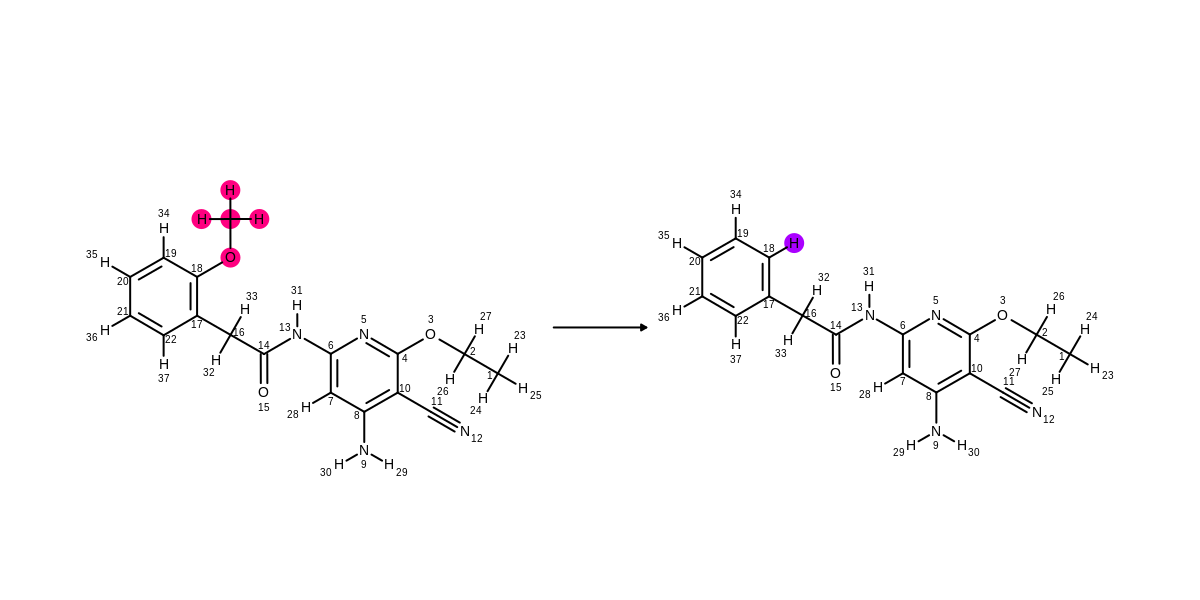

In [27]:
# try to open the perturbation image
try:
    from IPython.display import display, Image
    i = Image(filename=f'/Users/brucemah/bin/nn-endstates/data/jnk1-example/{folder}/render_complex_mapping.png')
    display(i)
except:
    print('Can\'t open image')

Loading the positions for the complex phase


  0%|          | 0/5001 [00:00<?, ?it/s]

Starting index of ligand in complex phase: 5993
42 atoms in the first ligand, and 38 atoms in the new ligand
Extracting the positions of the real molecules and calculating the MM energies


100%|██████████| 5001/5001 [00:55<00:00, 90.09it/s] 


Now calculating the ANI energies


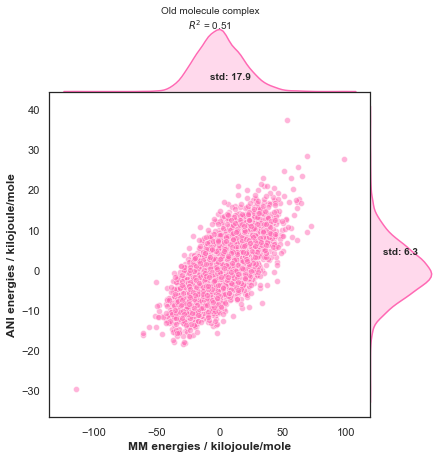

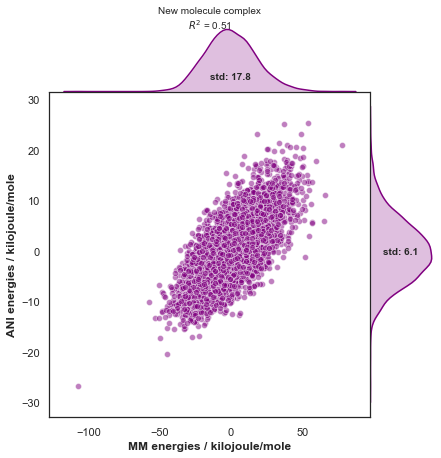

  0%|          | 15/5001 [00:00<00:33, 147.47it/s]

End point : -9806.09246142672 J/mol
End point error : 2837.0529644976123 J/mol
Loading the positions for the solvent phase
Starting index of ligand in solvent phase: 0
42 atoms in the first ligand, and 38 atoms in the new ligand
Extracting the positions of the real molecules and calculating the MM energies


100%|██████████| 5001/5001 [00:36<00:00, 136.07it/s]


Now calculating the ANI energies


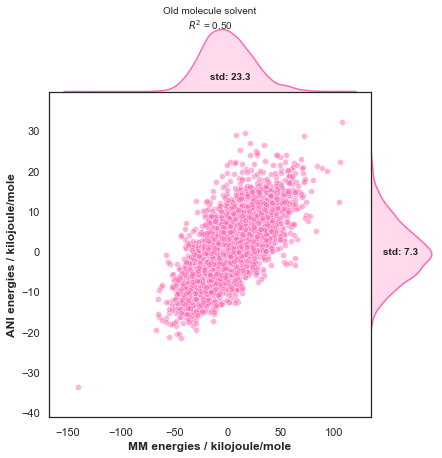

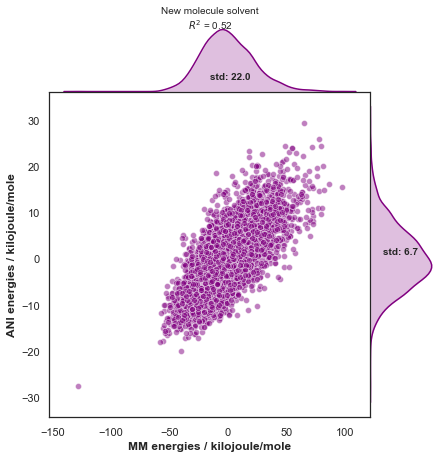

  0%|          | 13/5001 [00:00<00:39, 126.00it/s]

End point : -10492.51448551497 J/mol
End point error : 3394.966139258083 J/mol
Loading the positions for the vacuum phase
Starting index of ligand in vacuum phase: 0
42 atoms in the first ligand, and 38 atoms in the new ligand
Extracting the positions of the real molecules and calculating the MM energies


100%|██████████| 5001/5001 [00:35<00:00, 140.01it/s]


Now calculating the ANI energies


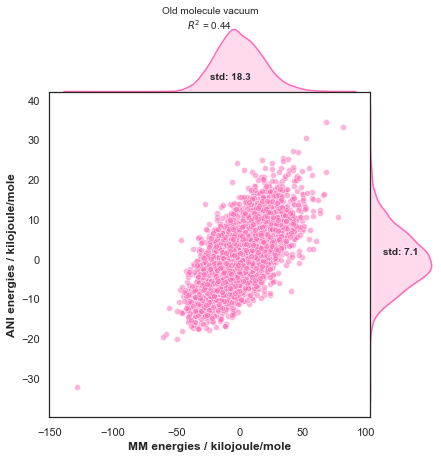

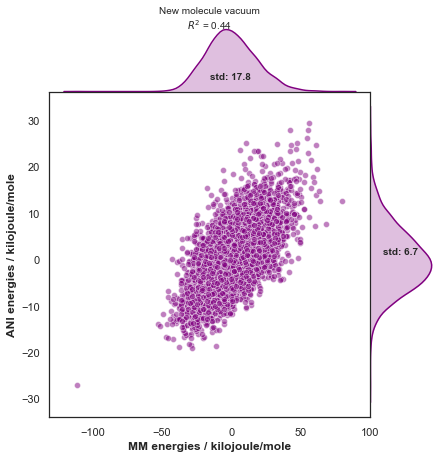

End point : 265.88021648338326 J/mol
End point error : 3340.9611474290123 J/mol


In [29]:
phases = ['complex', 'solvent', 'vacuum']

results = {}

for phase in phases:
    # load the output ncfile which contains the positions
    print(f'Loading the positions for the {phase} phase')
    filename = f'/Users/brucemah/bin/nn-endstates/data/jnk1-example/{folder}/out-{phase}.nc'
    if os.path.isfile(filename): # check it exists
        ncfile = Dataset(filename, 'r')
    else:
        print('ncfile doesn\t exist')
        
    old_topology = TPs[f'{phase}_topology_proposal'].old_topology
    new_topology = TPs[f'{phase}_topology_proposal'].new_topology


    old_topology_md = md.Topology.from_openmm(old_topology)
    new_topology_md = md.Topology.from_openmm(new_topology)
    
    
    old_molecule = [res for res in old_topology.residues() if res.name == 'MOL']
    molecule_indecies = [a.index for a in old_molecule[0].atoms()]
    old_string = ''.join([a.element.symbol for a in old_molecule[0].atoms()])
    n_old = len(molecule_indecies)
    start_id = molecule_indecies[0]


    new_molecule = [res for res in new_topology.residues() if res.name == 'MOL']
    molecule_indecies = [a.index for a in new_molecule[0].atoms()]
    new_string = ''.join([a.element.symbol for a in new_molecule[0].atoms()])
    n_new = len(molecule_indecies)
    print(f'Starting index of ligand in {phase} phase: {start_id}')
    
    # TODO add an assert that this is the same for all phases?
    print(f'{n_old} atoms in the first ligand, and {n_new} atoms in the new ligand') 
    
    n_iterations, n_replicas, _, _ = np.shape(ncfile.variables['positions'])

    MM_old = np.zeros(shape=(n_iterations))
    MM_new = np.zeros(shape=(n_iterations))

    all_old_positions = np.zeros(shape=(n_iterations,n_old,3))
    all_new_positions = np.zeros(shape=(n_iterations,n_new,3))


    old_positions = np.zeros(shape=(n_old,3))
    new_positions = np.zeros(shape=(n_new,3))    
    
    print(f'Extracting the positions of the real molecules and calculating the MM energies')
    for i in tqdm(range(n_iterations)): 
        # getting positions for lambda = 0
        positions = get_positions(ncfile, i, 0)   

        for hybrid, old in htf['vacuum']._hybrid_to_old_map.items():
            old_positions[old] = positions[hybrid+start_id]
        old_context.setPositions(old_positions)

        all_old_positions[i] = old_positions

        result = old_context.getState(getEnergy=True).getPotentialEnergy()
        MM_old[i] = result / result.unit

        # getting positions for lambda = 1
        positions = get_positions(ncfile, i, n_replicas-1)   
        for hybrid, new in htf['vacuum']._hybrid_to_new_map.items():
            new_positions[new] = positions[hybrid+start_id]
        new_context.setPositions(new_positions)
        result = new_context.getState(getEnergy=True).getPotentialEnergy()

        MM_new[i] = result / result.unit        

        all_new_positions[i] = new_positions

        
    # normalise
    MM_old = MM_old - np.mean(MM_old)     
    MM_new = MM_new - np.mean(MM_new) 
    
    # re-add units
    MM_old = MM_old * result.unit 
    MM_new = MM_new * result.unit
    
    print(f'Now calculating the ANI energies')    
    
    old_species = model.species_to_tensor(old_string).unsqueeze(0)
    ANI_old = compute_ani_energy(old_species, all_old_positions)
    # normalising
    ANI_old = ANI_old - np.mean(ANI_old)

    new_species = model.species_to_tensor(new_string).unsqueeze(0)

    ANI_new = compute_ani_energy(new_species, all_new_positions)
    # normalising
    ANI_new = ANI_new - np.mean(ANI_new)

    plot_mm_vs_ani(MM_old,ANI_old,color='hotpink',title=f'Old molecule {phase}\n')
    plot_mm_vs_ani(MM_new,ANI_new,color='purple',title=f'New molecule {phase}\n')

    ### reweight
    old_endpoint_reduced_works = (ANI_old - MM_old) / kBT
    new_endpoint_reduced_works = (ANI_new - MM_new) / kBT
    
    old_correction = EXP(old_endpoint_reduced_works)[0] * kBT
    old_correction_err = EXP(old_endpoint_reduced_works)[1] * kBT
    new_correction = EXP(new_endpoint_reduced_works)[0] * kBT
    new_correction_err = EXP(new_endpoint_reduced_works)[1] * kBT
    endpoint_correction = old_correction - new_correction

    print(f'End point : {endpoint_correction}')
    correction_error = (old_correction_err**2 + new_correction_err**2)**0.5
    print(f'End point error : {correction_error}')
    results[phase] = (endpoint_correction, correction_error)
    
    # saving everything
    results[f'{phase}_old_ANI'] = ANI_old
    results[f'{phase}_new_ANI'] = ANI_new
    results[f'{phase}_old_MM'] = MM_old
    results[f'{phase}_new_MM'] = MM_new

In [30]:
# TODO bootstrap errors too.

corr = results['complex'][0] - results['solvent'][0]
corr_err = (results['complex'][1]**2 + results['solvent'][1]**2)**0.5
print(f'Binding correction: {corr / unit.kilocalorie_per_mole:.2f} ({corr_err / unit.kilocalorie_per_mole:.2f}) kcal/mol')
corr = results['solvent'][0] - results['vacuum'][0]
corr_err = (results['solvent'][1]**2 + results['vacuum'][1]**2)**0.5
print(f'Hydration correction: {corr / unit.kilocalorie_per_mole:.2f} ({corr_err / unit.kilocalorie_per_mole:.2f}) kcal/mol')

Binding correction: 0.16 (1.06) kcal/mol
Hydration correction: -2.57 (1.14) kcal/mol


In [ ]:
# TODO - closer to experiment or not?

In [ ]:
# TODO check if the correction is the same for each edge of the same node (it should be)